# Recurrent Neural Networks
## Results 

In [187]:
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
import pandas as pd 
import numpy as np
import argparse
import umap
import json
import os

from core.metrics import MaskedACC, CustomAccuracy
from core.callbacks import get_callbacks
from core.data import load_records
from core.model import RNNModel
from core.utils import plot_cm, get_metrics, label_df
from data.create_record import clean_alt_list

from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import Adam

# plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading Exp Configuration

In [2]:
exp_path = './experiments/fasttext_balanced'
with open(exp_path+'/conf.json') as file:
    conf = json.load(file)
conf

{'data': './data/records/all_contrib/',
 'p': './experiments/fasttext_balanced',
 'batch_size': 512,
 'vocab_size': 200000,
 'epochs': 2000,
 'n_batches': 200,
 'layers': 2,
 'units': 128,
 'zdim': 15,
 'dropout': 0.5,
 'lr': 0.001,
 'model': 'rnn'}

### Loading Record Data

In [3]:
batches, n_cls = load_records(os.path.join('./data/records/contributions/', 'test'),
                                   batch_size=conf['batch_size'],
                                   return_cls=True,
                                   get_all=True)
batches = batches.cache()

### Initialize model

In [4]:
model = RNNModel(num_units=conf['units'],
                 num_layers=conf['layers'],
                 num_cls=n_cls,
                 dropout=conf['dropout'])
metrics = [Recall(), CustomAccuracy()]

model.model(conf['batch_size']).summary()

model.compile(optimizer=Adam(lr=conf['lr']),
              loss=CategoricalCrossentropy(),
              metrics=metrics)
metrics = model.evaluate(batches.take(1))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Serie1 (InputLayer)             [(512, 100, 300)]    0                                            
__________________________________________________________________________________________________
Mask (InputLayer)               [(512, 100, 1)]      0                                            
__________________________________________________________________________________________________
rnn (RNN)                       (512, 128)           355840      Serie1[0][0]                     
                                                                 Mask[0][0]                       
__________________________________________________________________________________________________
dense (Dense)                   (512, 13)            1677        rnn[0][0]                    

### Loading weights and evaluate

In [5]:
expdir = '{}/train_model.h5'.format(conf['p'])
model.load_weights(expdir)
model.evaluate(batches)

17/17 [==============================] - 3s 186ms/step - loss: 0.7965 - recall: 0.7120 - Accuracy: 0.8599


[0.7965051531791687, 0.7120369076728821, 0.8599221706390381]

### Metrics and Confusion Matrix

In [6]:
y_pred, y_true, _ = model.predict(batches)

In [7]:
display_labels = np.load(os.path.join('./data/records/contributions/', 'classes.npy'), allow_pickle=True)

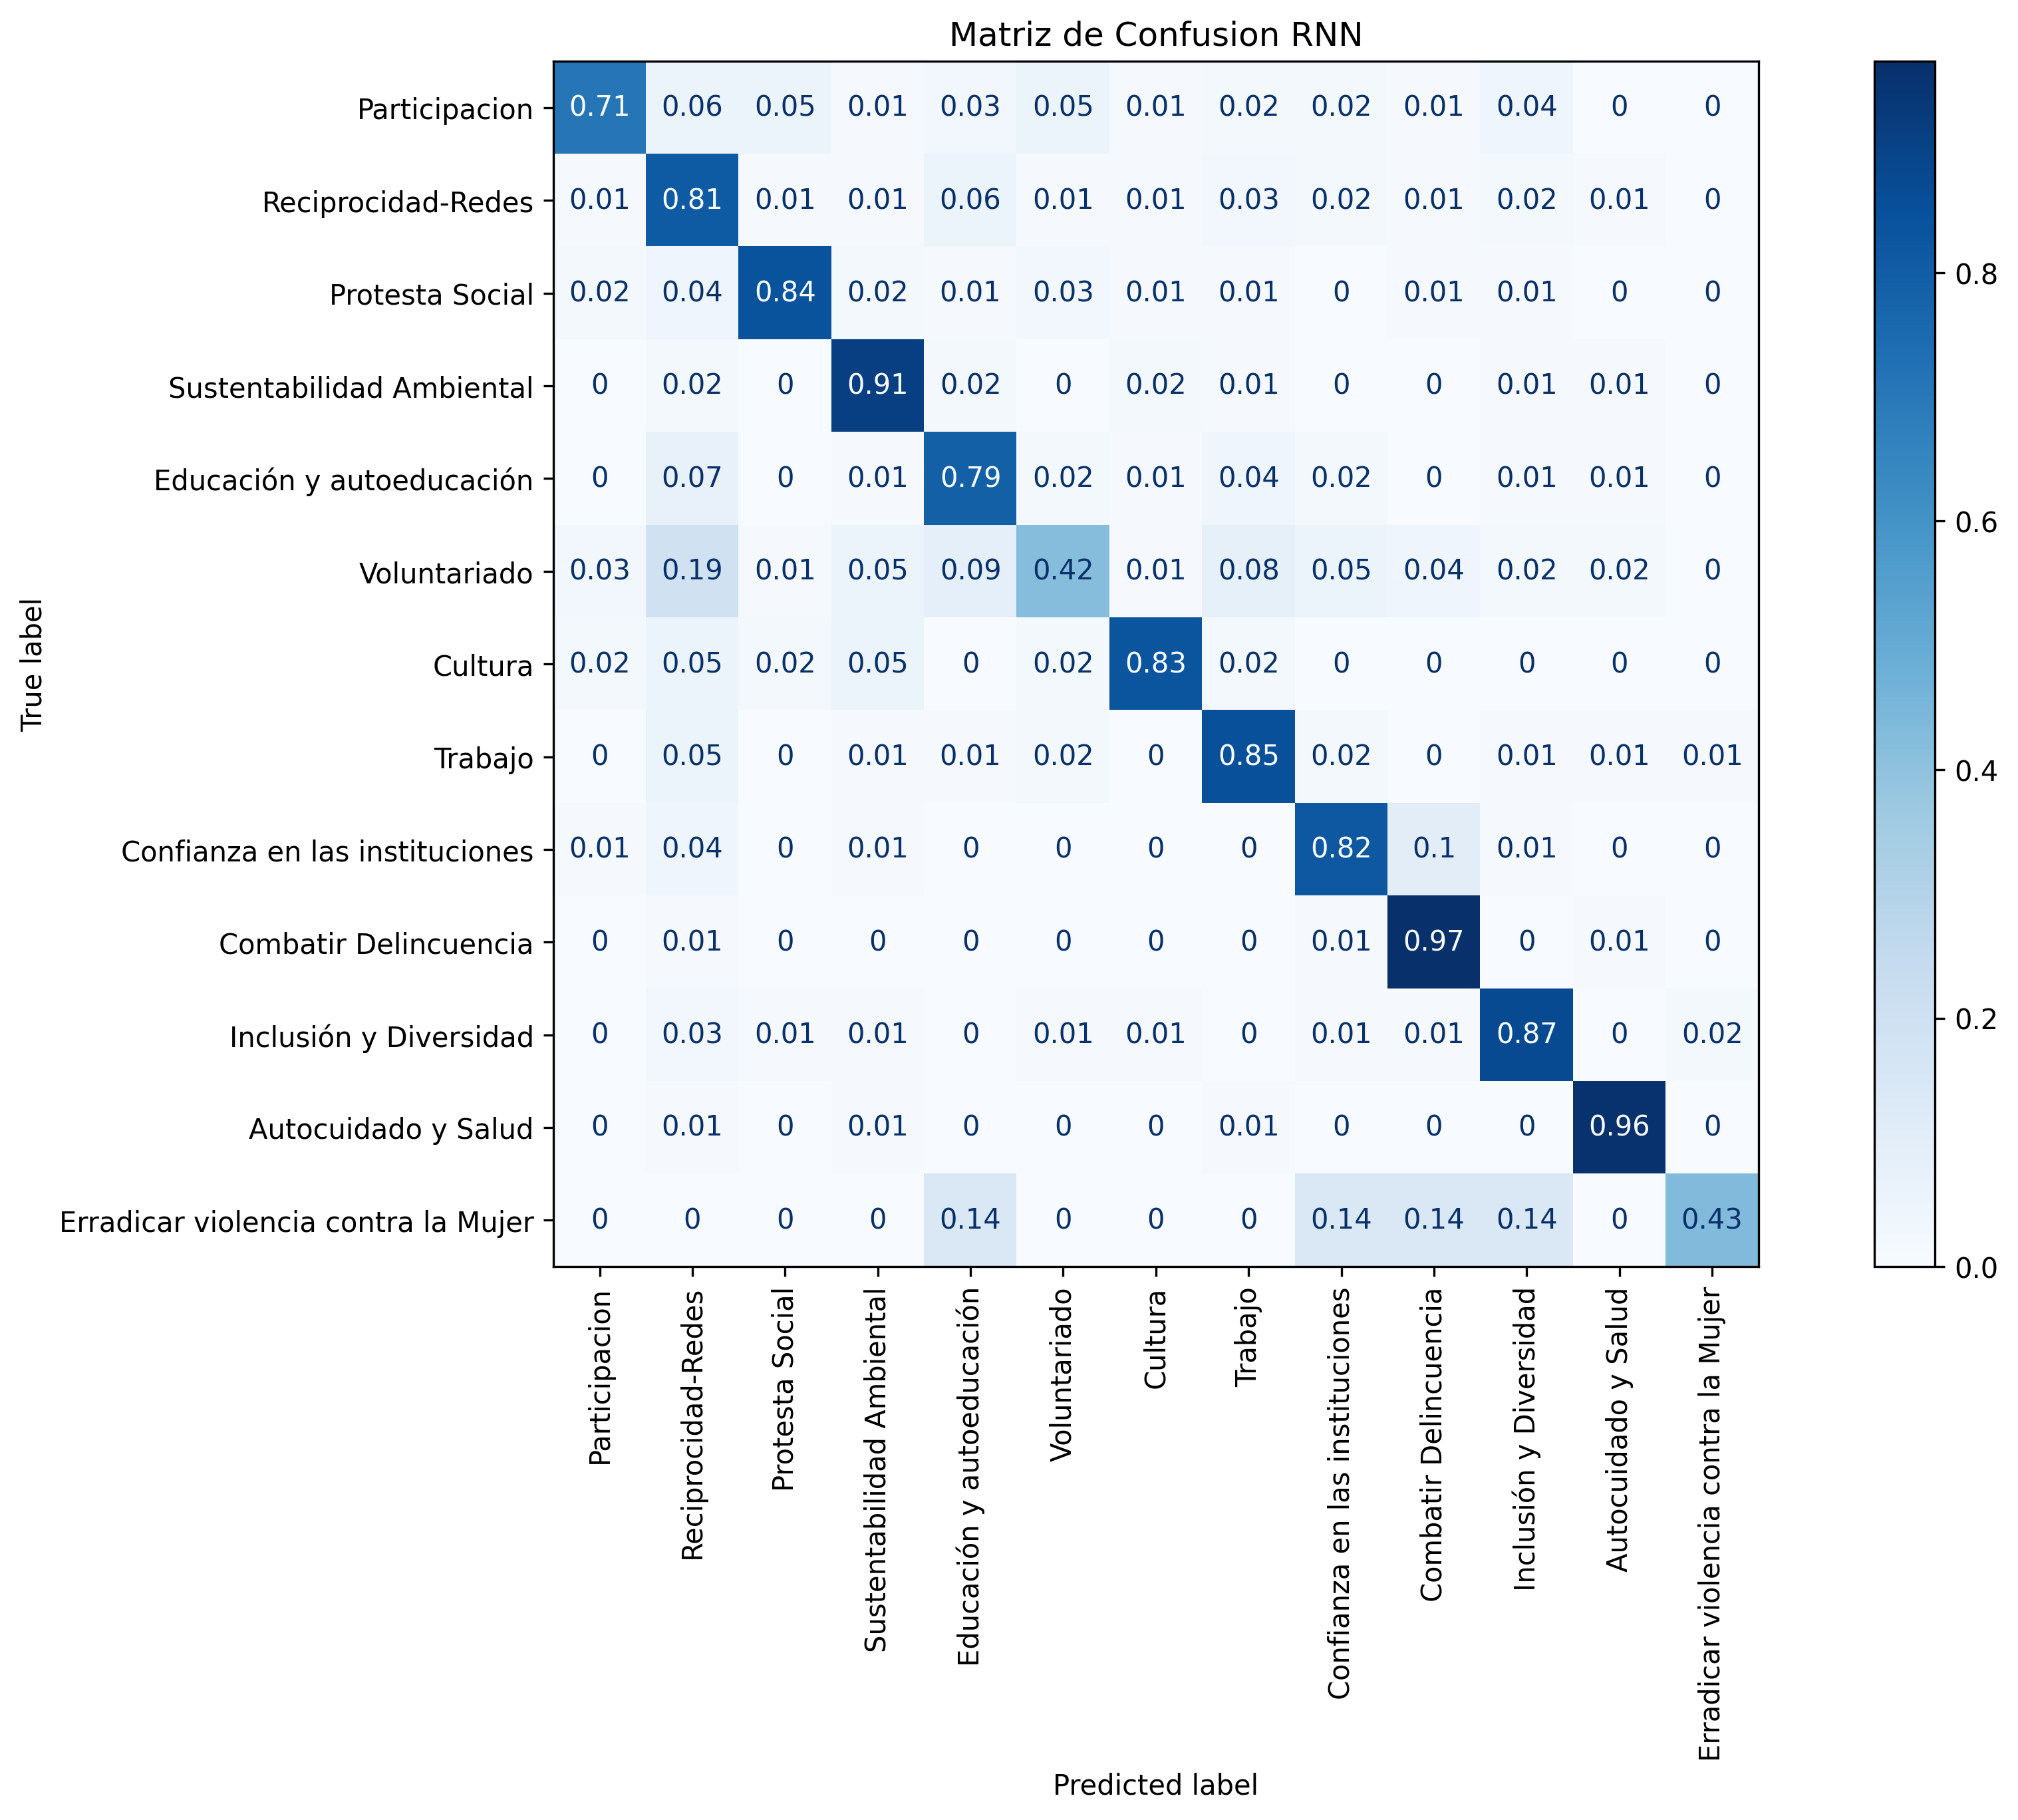

In [8]:
fig, ax = plt.subplots(1,1, dpi=300, figsize=(15, 8))
ax = plot_cm(y_true, y_pred, display_labels, ax)
ax.set_title('Matriz de Confusion RNN')
plt.show()

In [9]:
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

In [10]:
print('Precision: {:.2f}\nRecall: {:.2f}\nF1 Score: {:.2f}'.format(precision, recall, f1))

Precision: 0.59
Recall: 0.79
F1 Score: 0.65


### Learning Curves

In [11]:
path_logs = os.path.join(exp_path, 'train')
train_metrics = get_metrics(path_logs)

path_logs = os.path.join(exp_path, 'validation')
val_metrics = get_metrics(path_logs)

Text(0.52, -0.02, 'Number of Epochs')

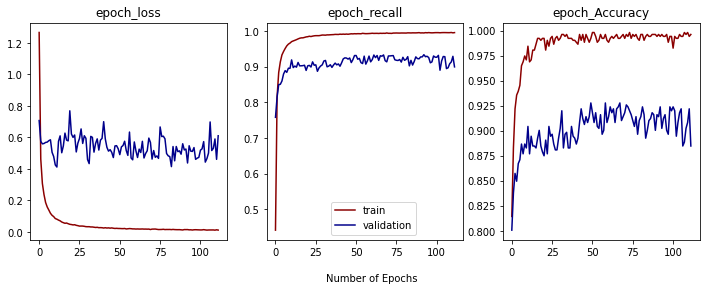

In [12]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
for i, key in enumerate(val_metrics.keys()):
    axes[i].plot(train_metrics[key]['steps'], train_metrics[key]['values'], label='train', color='darkred')
    axes[i].plot(val_metrics[key]['steps'], val_metrics[key]['values'], label='validation', color='darkblue')
    axes[i].set_title(key)
axes[1].legend(loc='center left', bbox_to_anchor=(0.3, 0.1))
fig.text(0.52, -0.02, 'Number of Epochs', ha='center')

### Predicting All Light Curves

In [14]:
pred_batches, n_cls = load_records(os.path.join('./data/records/contributions/', 'prediction'),
                                   batch_size=conf['batch_size'],
                                   return_cls=True,
                                   get_all=True)
pred_batches = pred_batches.cache()

In [15]:
y_pred , _, texts = model.predict(pred_batches)

In [16]:
pred_labels = [display_labels[x] for x in y_pred]

In [17]:
partial = pd.DataFrame()
partial['text'] = [t[0].decode('utf8') for t in texts]
partial['pred'] = pred_labels

In [18]:
data = pd.read_csv('./data/files/contributions.csv')
data['tokens'] = data['tokens'].apply(clean_alt_list)

In [20]:
%%time
final = label_df(data, partial)

[INFO] Using 8 cores
CPU times: user 17min 24s, sys: 1min 3s, total: 18min 28s
Wall time: 20min 2s


In [22]:
final.to_csv('contrib_models_comparison.csv', index=False)

### Final Table (Keep handwritten labels + RNN)

In [46]:
contrib_df = pd.read_csv('contrib_models_comparison.csv')
indices_nr = contrib_df[contrib_df['label'] == 'NR'].index
indices_labeled = contrib_df[contrib_df['label'] != 'NR'].index
macro_final = pd.concat([contrib_df['label'].iloc[indices_labeled], contrib_df['rnn'].iloc[indices_nr]])

In [48]:
final_table = contrib_df.iloc[:, :4]
final_table['macro'] = macro_final
final_table.sample(5)

,con_id,text,tokens,label,macro
45495,45495,educar.,['educar'],Educación y autoeducación,Educación y autoeducación
30400,30400,aportar lo más que pueda en educación,"['aportar', ' mas', ' pueda', ' educacion']",Reciprocidad-Redes,Reciprocidad-Redes
53145,53145,al trabajo de manera honrada.,"['trabajo', ' manera', ' honrada']",NR,Trabajo
14747,14747,Volver a generar un tejido de barrio (ejemplo ...,"['volver', ' generar', ' tejido', ' barrio'...",Participacion,Participacion
29971,29971,cuidar nuestro entorno,"['cuidar', ' entorno']",Sustentabilidad Ambiental,Sustentabilidad Ambiental


In [49]:
final_table.to_csv('./data/files/contributions_v4.csv')

### Visualizing Ditributions

In [81]:
y_probas, y_true, y_text = model.predict_proba(batches)

In [229]:
n = np.random.randint(0, len(y_true))

Text(0.5, 1.0, 'Etiqueta Real: Participacion\nTexto:informar y educar a mis vecinos')

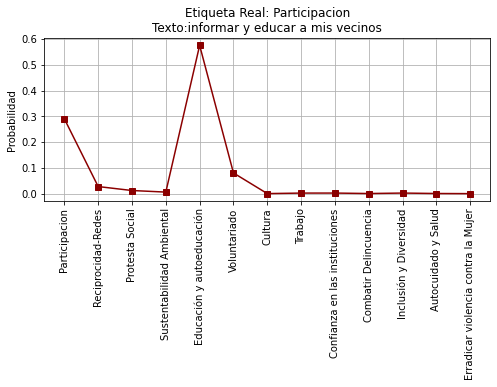

In [230]:
fig, axes = plt.subplots(1,1, figsize=(8, 3))

axes.plot(y_probas[n], color='darkred', marker='s')
axes.set_xticks(range(len(display_labels)))
axes.set_xticklabels(display_labels, rotation=90)

axes.set_ylabel('Probabilidad')
axes.grid(True)
t = y_text[n].numpy()[0].decode('utf8')
l = display_labels[y_true[n]]
axes.set_title('Etiqueta Real: {}\nTexto:{}'.format(l, t))

### Latent Space

In [177]:
states, y_true, y_text = model.get_latent(batches)

In [181]:
reducer = umap.UMAP()
scaled_states = StandardScaler().fit_transform(states)

In [182]:
%%time
embedding = reducer.fit_transform(scaled_states)

In [199]:
texts = [x.numpy()[0].decode('utf8') for x in y_text]

In [210]:

fig = px.scatter(x=embedding[:, 0], y=embedding[:, 1], hover_name=texts, title='Visualizacion del Estado Oculto de la RNN')
fig.show()